# CIFAR10 Classifier: PyTorch Edition

## Objective

Build a simple CIFAR10 classification model that runs on **GPU** using following:
- Resnet 50 as backbone
- Minimal augmentation
- Experiment tracking using Comet ML

## Expected Outcome
By the end of this post, you will be able to:
- use backbone (VGG,EfficientNet,ResNext...) of your choice
- use the dataset of your choice or the ones available on tensorflow datasets
- use Comet ML in your projects


Most of the content is similar to the tensorflow version of the notebook. This notebook takes full inspiration from the pytorch tutorial.

You could also refer to the one available at <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html">PyTorch Website</a>

---
@Date: 19-Aug-2020 | @Author: Katnoria

# 1. Setup Imports

In [1]:
import os
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# load from .env
from pathlib import Path
from dotenv import load_dotenv
# Comment these out if you do not wish to use comet
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader, random_split

# If you wish to use tensorboard
# from tensorboardX import SummaryWriter

# For Confusion Matrix
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Load secrets
%load_ext dotenv
%dotenv ../../.env

In [4]:
COMET_ML_API_KEY = os.getenv("COMET_ML_API_KEY")
len(COMET_ML_API_KEY)

25

In [5]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [6]:
print("Version Used in this Notebook:")
version_info(torch)
version_info(np)
import matplotlib as mpl
version_info(mpl)
import tqdm as tq
version_info(tq)
import comet_ml as cml
version_info(cml)

Version Used in this Notebook:
torch: 1.6.0
numpy: 1.18.5
matplotlib: 3.3.2
tqdm: 4.48.2
comet_ml: 3.2.0


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 2. Dataset

In [8]:
# Hyper params
BATCH_SIZE=128
NUM_WORKERS=12

In [9]:
# We are not using any augmentations here
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tuple([0.5]*3), tuple([0.5]*3))
])

In [10]:
# Load the dataset
train_ds = datasets.CIFAR10(
    root="./data", train=True, 
    download=True, transform=transform
)
# Create train and validation splits
train, val = random_split(train_ds, [45000, 5000])
# Create data loaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified


In [11]:
# Load test dataset
test_ds = datasets.CIFAR10(
    root="./data", train=False, 
    download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified


## 2.1 Review Data

We plot some images from the training set.

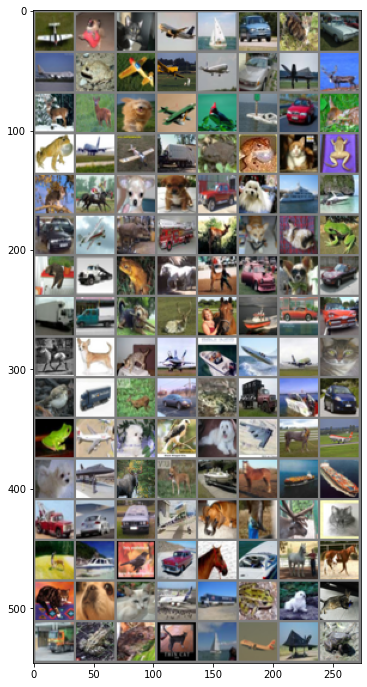

In [12]:
# Display images
images, labels = iter(train_loader).next()

# see: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(utils.make_grid(images))

# 3. Build Model

We will use imagenet pre-trained ResNet50 model. You can swap out the base model with others such as ResNet 18 or ResNet 110. Just make sure the input features of the final layer matches with the out features of your base model.

In [15]:
base_model = models.resnet50(pretrained=True)
# We do not want to
for param in base_model.parameters():
    param.requires_grad = False

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, base_model):
        super(SimpleNet, self).__init__()
        self.base_model = base_model
        # FC will be set as requires_grad=True by default
        self.base_model.fc = nn.Linear(2048, 10)
        
    def forward(self, x):
        x = self.base_model(x)
        return x
    
net = SimpleNet(base_model)
net.to(device);

Define your optimizer and loss functions

In [17]:
# Optimizer and loss function
# Hyperams are same as here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
LR=1e-3
MOMENTUM=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

And, the training loop

In [35]:
# Define the training loop
def train(epochs, net, metric_logger=None):
    pbar = tqdm(range(epochs))
    best_loss = np.inf
    for idx, epoch in enumerate(pbar):
        # set the network into training mode
        net.train()
        epoch_loss = 0
        running_corrects = 0
        for idx, record in enumerate(train_loader):
            images, labels = record
            images = images.to(device)
            labels = labels.to(device)
            # zero grad the optimizer
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                preds = net(images)
                loss = criterion(preds, labels)                
                loss.backward()
                optimizer.step()               
                # track losses
                epoch_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                running_corrects += torch.sum(predicted == labels).item()
                
        train_loss = epoch_loss / len(train_loader)
        train_acc = running_corrects / len(train_loader)
#         print(f"{epoch}/{epochs}: train loss {train_loss:.4f}")
        pbar.set_description(f"Train Loss: {train_loss:4f} | Acc: {train_acc:.4f}")
        if epoch_loss < best_loss:
            save(net, epoch, epoch_loss)
            best_loss = epoch_loss
            
        # Validation accuracy
        val_acc = test_model(net, val_loader)
        if metric_logger is not None:
            metric_logger.log_epoch("train_loss", train_loss, epoch)            
            metric_logger.log_epoch("train_acc", train_acc, epoch)
            metric_logger.log_epoch("val_acc", val_acc, epoch)        


def predict(model, loader):
    """
    Predicts the images from the given loader    
    """
    model.eval()
    predictions = []
    true_labels = []
    for idx, record in enumerate(loader):
        images, labels = record
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

def test_model(model, loader):
    """
    Utility method to get the accuracy of the model
    """    
    corrects = 0
    predicted, labels = predict(model, loader)
    corrects += np.sum(np.array(predicted) == np.array(labels))
    return corrects/len(loader)            

def save(model, epoch, loss):
    """
    Saves the model to the local directory
    """
    today = datetime.now().strftime("%Y%m%d")
    dirname = f"models/{today}"
    filename = f"{dirname}/cf10-pytorch.pt"
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f"{filename}")

## 4. Custom Metric Logger

You can ignore this part, it is just a wrapper to log metrics to the relevant experiment tracker.

In [21]:
import abc

class MetricLogger(abc.ABC):
    """Utility class to log metrics"""
    def __init__(self, writer):
        self.writer = writer
        
    @abc.abstractmethod
    def log_epoch(self, label, metric, epoch):
        return
    
    @abc.abstractmethod
    def log(self, label, metric):
        return
        
class TBMetricLogger(MetricLogger):
    """Tensorboard metric logger"""
    def __init__(self, writer):
        self.writer = writer        
        
    def log_epoch(self, label, metric, epoch):
        self.writer.add_scalar(label, metric, epoch)        
        
    def log(self, label, metric):
        self.writer.add_scalar(label, metric)
        
class CometMetricLogger(MetricLogger):
    """Comet metric logger"""
    def __init__(self, experiment):
        self.experiment = experiment
        self.label_map = {
            "train_acc": "batch_accuracy",
            "train_loss": "batch_loss",
            "val_acc": "batch_val_accuracy",
            "test_acc": "accuracy"
        }
        
    def log_epoch(self, label, metric, epoch=None):
        metric_label = self.label_map[label]
        self.experiment.log_metric(metric_label, metric, epoch)        
        
    def log(self, label, metric):
        self.experiment.log_metric(label, metric)

In [22]:
def get_confusion_matrix(model, loader):
    """Returns the confusion matrix"""
    predicted, true_labels = predict(model, loader)    
    cm = confusion_matrix(true_labels, predicted)
    return {
        "predicted": predicted,
        "true_labels": true_labels,
        "matrix": cm
    }

# 5. Train

We are now ready to train our model.

In [23]:
EPOCHS=50

## 5.1: Track Experiments
You can track your experiments using tensorboard, w&b or any other tool. I am using comet in this notebook. I quite like the overall experience with [comet ml](https://www.comet.ml/).

### 5.1.1: Tensorboard 

Train and log metrics to Tensorboard. Uncomment this section, if you wish to train and log using tensorboard

In [24]:
# # TRAIN
# metric_logger = TBMetricLogger(experiment)
# writer = SummaryWriter("runs/simple_model")
# train(EPOCHS, net, metric_logger)

### 5.1.2: Comet 
Train and log metrics to comet.

In [25]:
experiment = Experiment(api_key=COMET_ML_API_KEY,
                        project_name="cf10-pytorch", workspace="katnoria")
# add a tag
experiment.add_tag("R50+Dense")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katnoria/cf10-pytorch/a77812fdf6794736a6a7737b01f25206



In [26]:
metric_logger = CometMetricLogger(experiment)
start = time()
print(f"start: {datetime.fromtimestamp(start)}")

with experiment.train():
    train(EPOCHS, net, metric_logger)
stop = time()

start: 2020-10-16 09:08:27.917127


In [32]:
took = stop - start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  7m 3s


In [36]:
with experiment.test():
    test_accuracy = test_model(net, test_loader)
    print(f"Test Accuracy {test_accuracy}")
    metric_logger.log("test_acc", test_accuracy)    

Test Accuracy 69.26582278481013


In [38]:
hyper_params = {
    "batch_size": BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "learning_rate": LR,
    "momentum": MOMENTUM,
    "num_epochs": EPOCHS,
    "lr_scheduler_step": exp_lr_scheduler.step_size
}
experiment.log_parameters(hyper_params)

## 5.2: Confusion Matrix

Let's plot to confusion matrix to find out more how much of predictions does our model get right.

In [39]:
cm = get_confusion_matrix(net, val_loader)

In [40]:
cm["matrix"]

array([[255,  18,  57,   8,   6,   4,   8,  18,  92,  22],
       [ 11, 318,  13,  18,   7,   7,  11,  16,  41,  70],
       [ 38,   8, 272,  25,  46,  22,  55,  35,  25,   6],
       [ 14,  15,  38, 181,  25,  73,  42,  48,  24,  11],
       [ 11,   7,  43,  24, 224,  20,  52,  64,  17,   9],
       [  7,  16,  47,  74,  28, 222,  40,  55,  12,  13],
       [ 11,   9,  41,  28,  38,  17, 341,  12,   5,   5],
       [ 14,  16,  27,  27,  46,  24,  14, 297,  13,  22],
       [ 72,  21,  11,  12,   6,   4,   9,  12, 338,  19],
       [ 17,  60,   5,  15,   8,  16,  10,  30,  48, 292]])

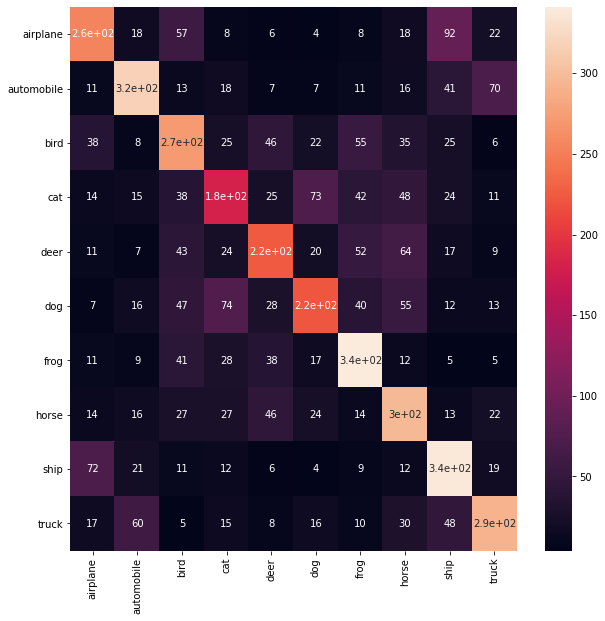

In [41]:
labels = [label for label in train_ds.classes]
df = pd.DataFrame(cm["matrix"], index=labels, columns=labels)
plt.figure(figsize=(10,10))
sns.heatmap(df, annot=True)
plt.show()

We see the model gets confused between:
* `bird` and a `airplane` (It's a Bird, It's a Plane, It's Superman 😎)
* `airplane` and `ship`
* `automobile` and `truck`
* `cat` and `dog`...seriously??

## 5.2.1 Check the images

Let us plot some images of ship and airplane

In [82]:
# Display images
def plot_cls_images(class_name='airplane'):
    images, labels = iter(train_loader).next()
    filtered_images = [img for img, label in zip(images, labels.numpy()) if label == train_ds.classes.index(class_name)]

    # see: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    def show_filtered_images(imgs):
        imgs = imgs / 2 + 0.5     # unnormalize
        plt.figure(figsize=(12, 12))
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis('off')
        plt.title(f"{class_name.upper()}")
        plt.show()

    show_filtered_images(utils.make_grid(filtered_images))

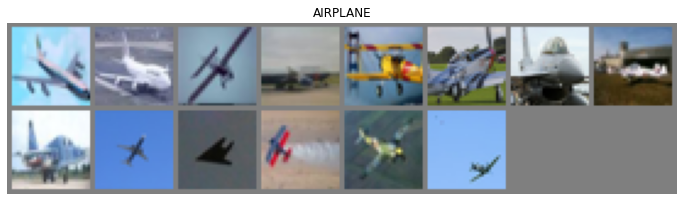

In [83]:
plot_cls_images('airplane')

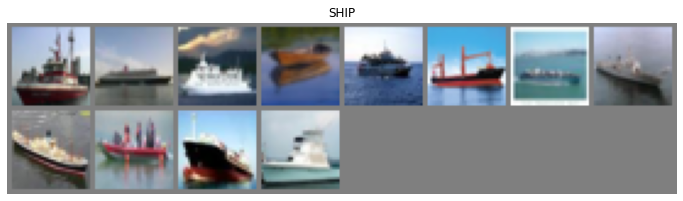

In [84]:
plot_cls_images('ship')

## 5.2.1: Add to Comet
Since we are using Comet, we can log the confusion matrix to the experiment

In [42]:
cm = get_confusion_matrix(net, val_loader)
experiment.log_confusion_matrix(matrix=cm['matrix'], title="Validation Set: Confusion Matrix")

{'web': 'https://www.comet.ml/api/asset/download?assetId=574a7e5a7fd34417a5914a882d2ff3b9&experimentKey=a77812fdf6794736a6a7737b01f25206',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=574a7e5a7fd34417a5914a882d2ff3b9&experimentKey=a77812fdf6794736a6a7737b01f25206',
 'assetId': '574a7e5a7fd34417a5914a882d2ff3b9'}

In [43]:
# You can also provide just the matrix
cm = get_confusion_matrix(net, test_loader)
experiment.log_confusion_matrix(matrix=cm['matrix'], title="Test Set: Confusion Matrix")

{'web': 'https://www.comet.ml/api/asset/download?assetId=cb047708927a4dceb665d0a1f9b5b11a&experimentKey=a77812fdf6794736a6a7737b01f25206',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=cb047708927a4dceb665d0a1f9b5b11a&experimentKey=a77812fdf6794736a6a7737b01f25206',
 'assetId': 'cb047708927a4dceb665d0a1f9b5b11a'}

In [44]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-pytorch/a77812fdf6794736a6a7737b01f25206
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_test_acc [2]             : (0.0, 69.26582278481013)
COMET INFO:     train_batch_accuracy [50]     : (48.77272727272727, 74.57954545454545)
COMET INFO:     train_batch_loss [50]         : (1.2125481666827744, 1.8231653838672421)
COMET INFO:     train_batch_val_accuracy [50] : 50
COMET INFO:     train_loss [1760]             : (0.9251222610473633, 2.4270572662353516)
COMET INFO:   Parameters:
COMET INFO:     batch_size        : 128
COMET INFO:     learning_rate     : 0.001
COMET INFO:     lr_scheduler_step : 7
COMET INFO:     momentum          : 0.9
COMET INFO:     num_epochs        : 50
COMET INFO:     num_workers       : 12
COMET I

# 6. Next Steps

This is a very simple example of training CIFAR10 classifier using a pre-trained network. Its your turn to tune the knob and see if you can get model to generalise better. Some ideas:

- make the model overfit your training data
- regularize the model to generalize better
- increase/decrease model capacity based on what you find in above steps
- add image augmentation
- use hyperparameter tuning library to find the best set of combination
- rollout your own model from scratch, you can use the tuning library to help design the network too


---

So we got 69.3%. The state of the art model, at the time of writing this notebook, is **99.4%** by [Big Transfer (BiT-L) Paper](https://arxiv.org/abs/1912.11370v3). How's that for the motivation 💪🏽.

Paper Abstract:
> Transfer of pre-trained representations improves sample efficiency and simplifies hyperparameter tuning when training deep neural networks for vision. We revisit the paradigm of pre-training on large supervised datasets and fine-tuning the model on a target task. We scale up pre-training, and propose a simple recipe that we call Big Transfer (BiT). By combining a few carefully selected components, and transferring using a simple heuristic, we achieve strong performance on over 20 datasets. BiT performs well across a surprisingly wide range of data regimes -- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark (VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class, and 97.0% on CIFAR-10 with 10 examples per class. We conduct detailed analysis of the main components that lead to high transfer performance.